### <font size=5>**Melanoma Detection - CNN Model**</font>

#### <font color='#000080' size=5>***Objective:***</font>
<font size=3>
To build a CNN model which can accurately detect Melanoma
</font>

#### <font color='#000080' size=5>***Data Sourcing:***</font>

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import pathlib
import glob
import os

In [110]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

In [111]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [112]:
%cd "/content/drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [113]:
!ls

model_plot.png	Rajani_Nagaraju_nn.ipynb  SkinCancer_CNN_Dataset


In [114]:
train_data_path=pathlib.Path("SkinCancer_CNN_Dataset/Train")
test_data_path=pathlib.Path("SkinCancer_CNN_Dataset/Test")

In [121]:
train_data_count = len(list(train_data_path.glob('*/*.jpg')))
test_data_count = len(list(test_data_path.glob('*/*.jpg')))
print("Train Data count: ", train_data_count)
print("Test Data count: ", test_data_count)

Train Data count:  2239
Test Data count:  118


### Create a Dataset

Load using keras.preprocessing

In [122]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [123]:
train_ds = image_dataset_from_directory(train_data_path,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123,subset="training",
                                                                    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [124]:
val_ds = image_dataset_from_directory(train_data_path,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123,subset="validation",
                                                                    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


 List out all the classes of skin cancer and store them in a list

In [125]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization

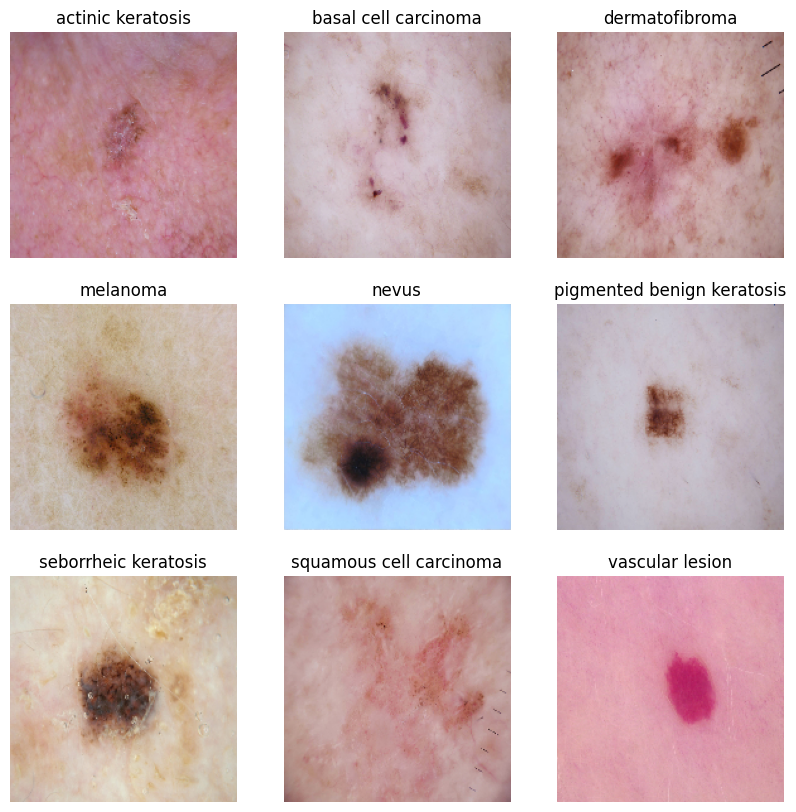

In [126]:
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(train_data_path)+'/'+c+'/'+x,os.listdir(str(train_data_path)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

#### <font color='#000080' size=5>***Model1 : CNN Model***</font>

### Auto tune the model

In [127]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a CNN Model

In [128]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

#Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range.
#This is not ideal for a neural network. Hence standardizing values to be in the range [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       7

Visualizing the model

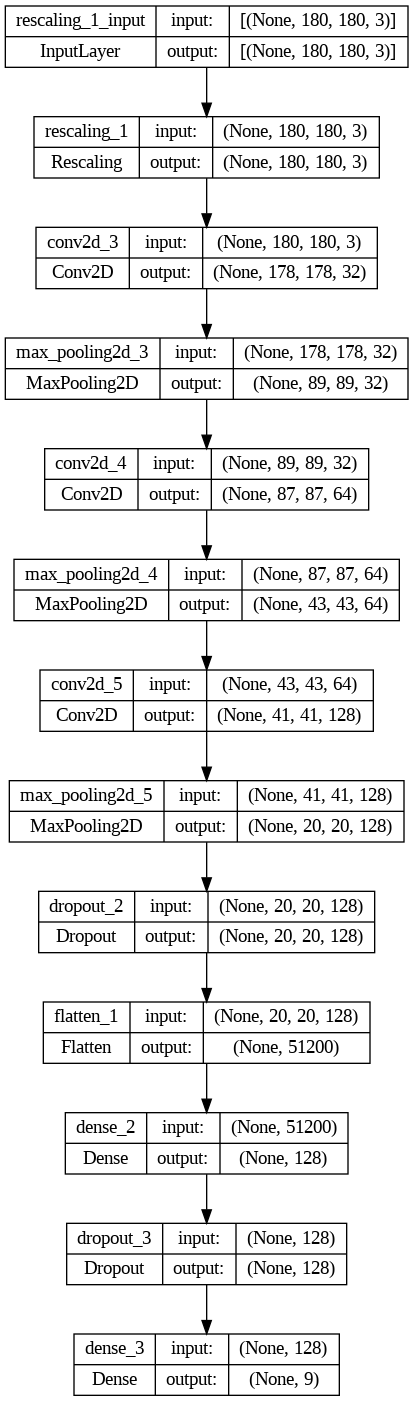

In [129]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [130]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [131]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 22s 114ms/step - loss: 2.0955 - accuracy: 0.2344 - val_loss: 1.9194 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7659 - accuracy: 0.3415 - val_loss: 1.5638 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5302 - accuracy: 0.4626 - val_loss: 1.4345 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4624 - accuracy: 0.4916 - val_loss: 1.4607 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4299 - accuracy: 0.4955 - val_loss: 1.4625 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3836 - accuracy: 0.5156 - val_loss: 1.4901 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3279 - accuracy: 0.5312 - val_loss: 1.4795 - val_accuracy: 0.4877
Epoch 8/20


Visualizing training results

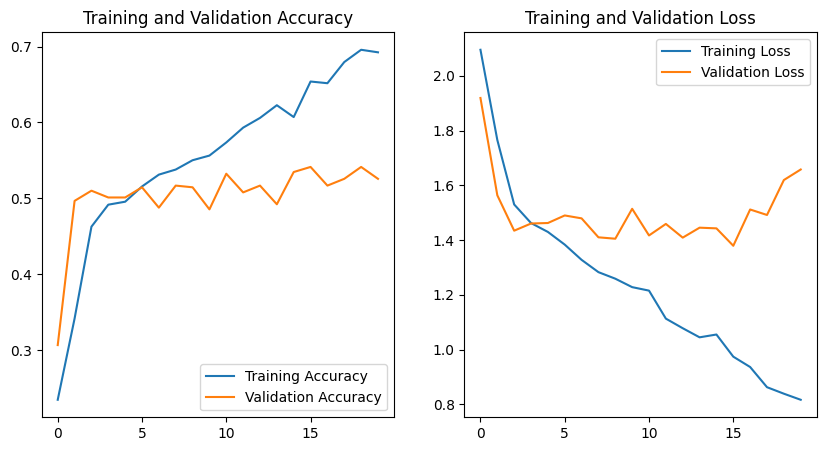

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above graph, it is very clear that there is a model overfitting. We could see that training accuracy steadily increses and goes as high as to about 70% while we see that there is no huge increase in validation accuracy and remains to be at 52%. Let us create an augmentation and layer and check if model performs better.

#### <font color='#000080' size=5>***Model2 : CNN with Augmentation***</font>

### Create Augmentation layer

In [133]:
# Build augmentation layer
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

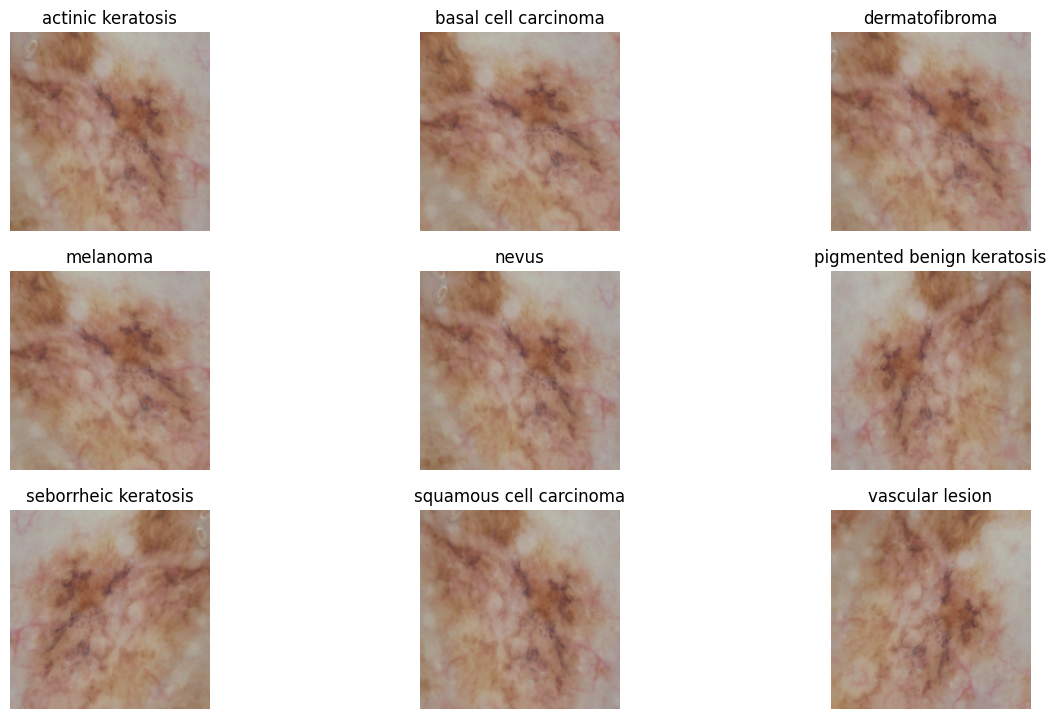

In [134]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

In [135]:
keras.backend.clear_session()
del model
del history

Create CNN Model

In [136]:
#CNN Model Architecture

model = data_augmentation

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                   

Visualizing the model

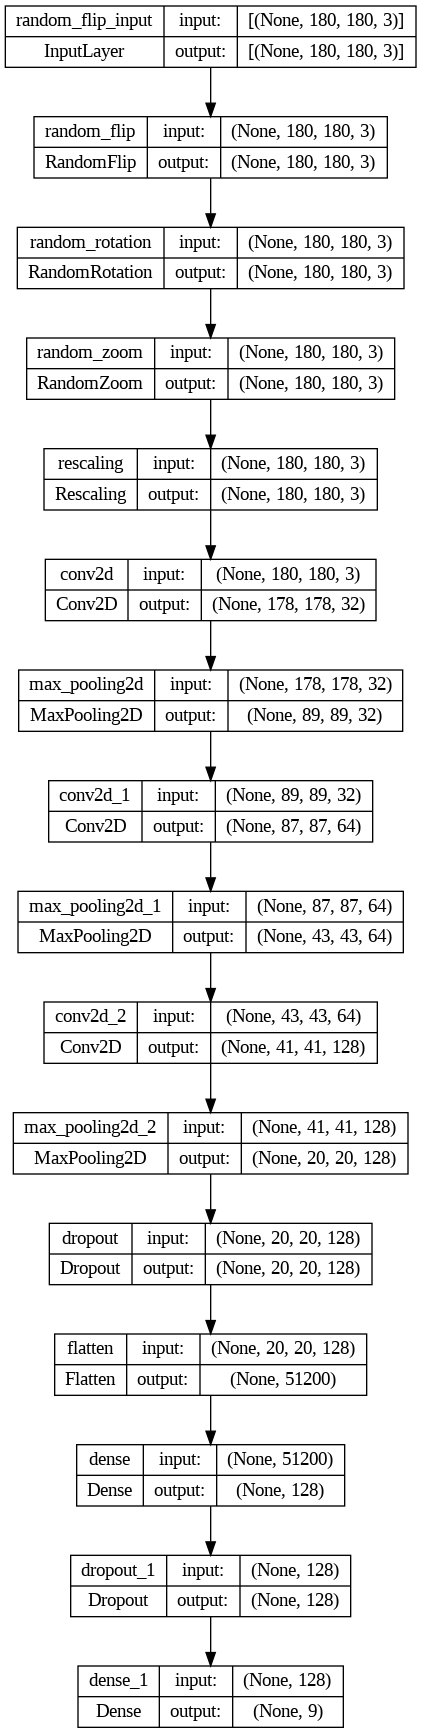

In [137]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [138]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [139]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 6s 59ms/step - loss: 2.0054 - accuracy: 0.2584 - val_loss: 1.7607 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7700 - accuracy: 0.3544 - val_loss: 1.7273 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6269 - accuracy: 0.4169 - val_loss: 1.5124 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.5451 - accuracy: 0.4626 - val_loss: 1.5641 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5170 - accuracy: 0.4660 - val_loss: 1.4717 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4323 - accuracy: 0.5073 - val_loss: 1.3661 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3994 - accuracy: 0.5050 - val_loss: 1.3342 - val_accuracy: 0.5548
Epoch 8/20
56

Visualizing training results

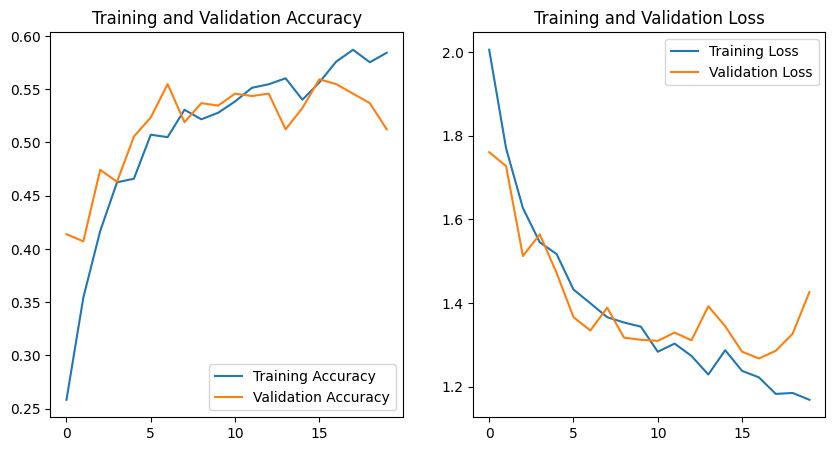

In [140]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we could see from the above graph, we have tackled the problem of overfitting. Accuracy in training data is 58% while on validation data is 51%. However, to improve the model learning, lets check the distribution of classes in training dataset.

Distribution of classes in Training Dataset

In [141]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train_data_path)
df

,Class,No. of Image
0,dermatofibroma,95
1,basal cell carcinoma,376
2,actinic keratosis,114
3,pigmented benign keratosis,462
4,vascular lesion,139
5,melanoma,438
6,nevus,357
7,squamous cell carcinoma,181
8,seborrheic keratosis,77


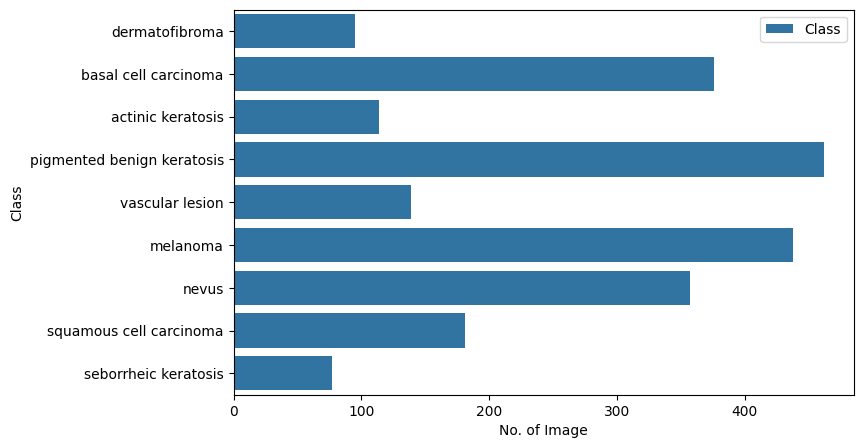

In [142]:
#Visualize the Number of image in each class.
plt.figure(figsize=(8, 5))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

As we could see from above, seborrheic keratosis, actinic keratosis and dermatofibroma has less number of samples, while pigmented benign keratosis	and melanoma dominate the data in terms of the proportionate number of samples.

There clearly there is a class imbalance and we shall solve this using a python package Augmentor to add more samples across all classes so that none of the classes have very few samples.

In [143]:
keras.backend.clear_session()
del model
del history

In [23]:
#install Augmentor
!pip install Augmentor

In [144]:
import Augmentor
path_to_training_dataset="SkinCancer_CNN_Dataset/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B270649B10>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B207287CA0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B207743100>: 100%|██████████| 500/500 [00:18<00:00, 27.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x78B2072491E0>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=796x682 at 0x78B213E45780>: 100%|██████████| 500/500 [01:25<00:00,  5.84 Samples/s]


Initialised with 462 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B214078280>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78B270649B10>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B214208160>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to SkinCancer_CNN_Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B294131F00>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


In [145]:
image_count_train = len(list(train_data_path.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [146]:
path_list = [x for x in train_data_path.glob('*/*.jpg')]

In [147]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in train_data_path.glob('*/*.jpg')]

In [148]:
dataframe_dict = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [149]:
path_list_new = [x for x in train_data_path.glob('*/output/*.jpg')]

In [150]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in train_data_path.glob('*/output/*.jpg')]


In [151]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [152]:
new_df = pd.concat([df,df2])
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

Create training dataset

In [154]:
train_ds = image_dataset_from_directory(train_data_path,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123,subset="training",
                                                                    validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create validation data set

In [155]:
val_ds = image_dataset_from_directory(train_data_path,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123,subset="validation",
                                                                    validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Auto tune the model

In [156]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a CNN Model

In [157]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

Visualizing the model

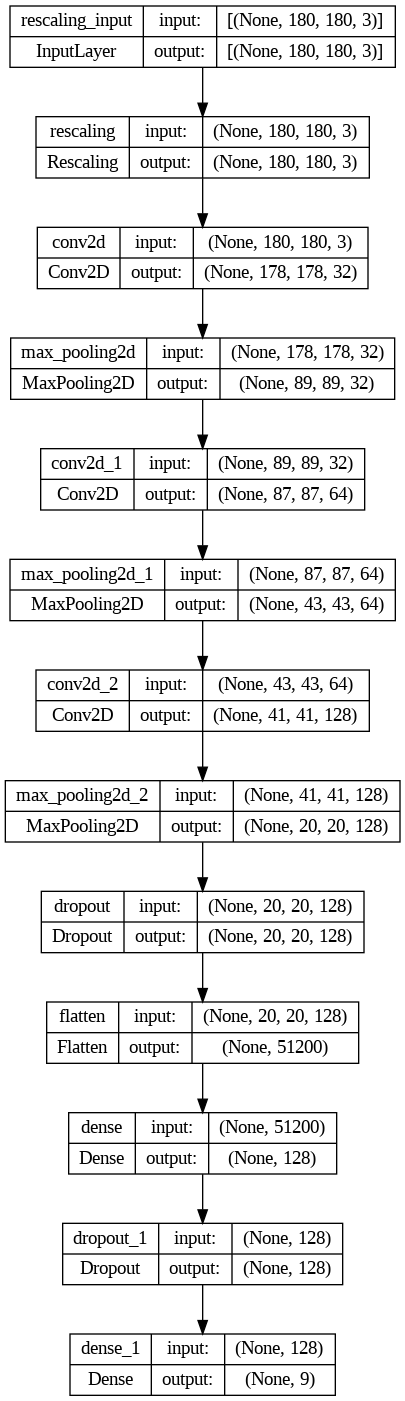

In [158]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Compile the Model

In [159]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

Train the model

In [160]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
169/169 [==============================] - 49s 95ms/step - loss: 1.9185 - accuracy: 0.2613 - val_loss: 1.6433 - val_accuracy: 0.3578
Epoch 2/20
169/169 [==============================] - 9s 53ms/step - loss: 1.5335 - accuracy: 0.4173 - val_loss: 1.4057 - val_accuracy: 0.4618
Epoch 3/20
169/169 [==============================] - 9s 52ms/step - loss: 1.3614 - accuracy: 0.4868 - val_loss: 1.3108 - val_accuracy: 0.5115
Epoch 4/20
169/169 [==============================] - 9s 51ms/step - loss: 1.2361 - accuracy: 0.5286 - val_loss: 1.2053 - val_accuracy: 0.5494
Epoch 5/20
169/169 [==============================] - 9s 53ms/step - loss: 1.1115 - accuracy: 0.5838 - val_loss: 1.2585 - val_accuracy: 0.5419
Epoch 6/20
169/169 [==============================] - 9s 52ms/step - loss: 1.0262 - accuracy: 0.6116 - val_loss: 0.9912 - val_accuracy: 0.6340
Epoch 7/20
169/169 [==============================] - 9s 51ms/step - loss: 0.9340 - accuracy: 0.6487 - val_loss: 1.0317 - val_accuracy: 0.637

Visualizing training results

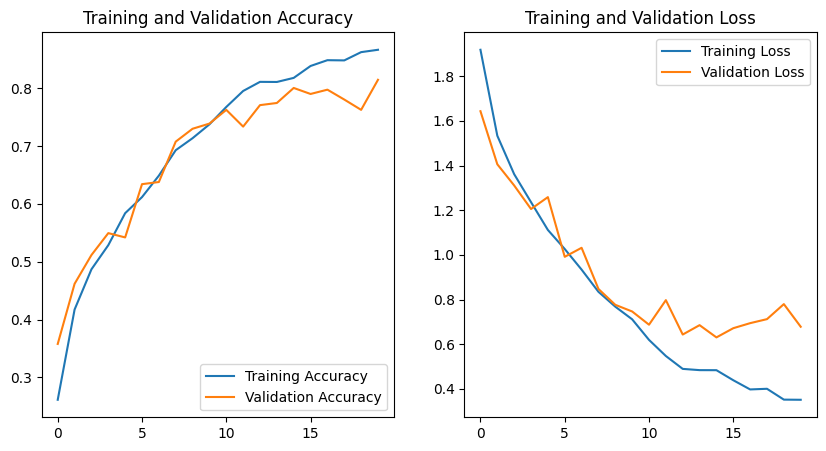

In [161]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above results we could see that model is performing pretty good with 86% accuracy on train data and 81% accuracy on test data